# Brain MRI Classification


### Load Dataset

In [1]:

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Required constants
TRAIN_DIR = '/kaggle/input/brain-tumor-mri-dataset/Training'
VALID_DIR = '/kaggle/input/brain-tumor-mri-dataset/Testing'

IMAGE_SIZE = 224 # Image size of resize when applying transforms.
BATCH_SIZE = 128
NUM_WORKERS = 4 # Number of parallel processes for data preparation.

# Training transforms
def get_train_transform(IMAGE_SIZE):
    train_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.185, 0.185, 0.185],
            std=[0.204, 0.204, 0.204]
            )
    ])
    return train_transform


# Validation transforms
def get_valid_transform(IMAGE_SIZE):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.185, 0.185, 0.185],
            std=[0.204, 0.204, 0.204]
            )
    ])
    return valid_transform


def get_datasets():
    """
    Function to prepare the Datasets.
    Returns the training and validation datasets along
    with the class names.
    """
    dataset_train = datasets.ImageFolder(
        TRAIN_DIR,
        transform=(get_train_transform(IMAGE_SIZE))
    )
    dataset_valid = datasets.ImageFolder(
        VALID_DIR,
        transform=(get_valid_transform(IMAGE_SIZE))
    )
    return dataset_train, dataset_valid, dataset_train.classes


def get_data_loaders(dataset_train, dataset_valid):
    """
    Prepares the training and validation data loaders.
    :param dataset_train: The training dataset.
    :param dataset_valid: The validation dataset.
    Returns the training and validation data loaders.
    """
    train_loader = DataLoader(
        dataset_train, batch_size=BATCH_SIZE,
        shuffle=True, num_workers=NUM_WORKERS, pin_memory=False
    )
    valid_loader = DataLoader(
        dataset_valid, batch_size=BATCH_SIZE,
        shuffle=False, num_workers=NUM_WORKERS, pin_memory=False
    )
    return train_loader, valid_loader



### Model

In [2]:
import torchvision.models as models
import torch.nn as nn


def build_model(pretrained=True, fine_tune=True, num_classes=4):
    if pretrained:
        print("[INFO]: Loading pre-trained weights")
    else:
        print("[INFO]: NOt loading pre-Trained weights")
    model = models.efficientnet_b0(pretrained=pretrained)

    if fine_tune:
        print("[INFO]: Fine-tuning all layers...")
        for params in model.parameters():
            params.requires_grad=True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False

    # Change the final classification head.
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model



### Save Model and plot functions

In [3]:
import torch
import matplotlib.pyplot as plt


def save_model(epochs, model, optimizer, criterion, output_path:str='./output_model.pth'):
    """
    Function to save the trained model
    :param epochs:
    :param model:
    :param optimizer:
    :param criterion:
    :param output_path:
    :return:
    """
    torch.save({
        'epoch':epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),
        'loss': criterion,
    }, f=output_path)


def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    :param train_acc:
    :param valid_acc:
    :param train_loss:
    :param valid_loss:
    :return:
    """
    # accuracy plots
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig("accuracy.png")

    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig("loss.png")



### Training

In [4]:
import torch
import argparse
import torch.nn as nn
import torch.optim as optim
import time

from tqdm.auto import tqdm


In [5]:
# Learning_parameters.
lr = 0.0001
epochs = 15


In [6]:
# Training function.
def train(model, trainloader, optimizer, criterion, device:str="cuda"):
    """
    Train the model with training dataset
    :param model:
    :param trainloader:
    :param optimizer:
    :param criterion:
    :param cuda:
    :return:
    """
    model.train()
    print("Training...")
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        image, labels = data
        image, labels = image.to(device), labels.to(device)

        # zero gradient
        optimizer.zero_grad()
        # forward pass
        outputs = model(image)
        # calculate the loss
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # update weights
        optimizer.step()

    # Loss and accuracy for the whole epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc


# Validation function.
def validate(model, testloader, criterion, device:str="cuda"):
    """
    Validate the validation dataset
    :param model:
    :param testloader:
    :param criterion:
    :param cuda:
    :return:
    """
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # calculate the loss
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc


[INFO]: Number of training images: 5712
[INFO]: Number of validation images: 1311
[INFO]: Class names: ['glioma', 'meningioma', 'notumor', 'pituitary']

Computation device: cuda
Learning rate: 0.0001
Epochs to train for: 15

[INFO]: Loading pre-trained weights


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weigh

  0%|          | 0.00/20.5M [00:00<?, ?B/s]

[INFO]: Fine-tuning all layers...
4,012,672 total parameters.
4,012,672 training parameters.
[INFO]: Epoch 1 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.784, training acc: 74.282
Validation loss: 0.627, validation acc: 77.651
--------------------------------------------------
[INFO]: Epoch 2 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.270, training acc: 91.001
Validation loss: 0.375, validation acc: 90.236
--------------------------------------------------
[INFO]: Epoch 3 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.161, training acc: 94.188
Validation loss: 0.393, validation acc: 94.127
--------------------------------------------------
[INFO]: Epoch 4 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.113, training acc: 96.218
Validation loss: 1.867, validation acc: 95.957
--------------------------------------------------
[INFO]: Epoch 5 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.084, training acc: 97.181
Validation loss: 0.573, validation acc: 96.491
--------------------------------------------------
[INFO]: Epoch 6 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.064, training acc: 97.864
Validation loss: 0.176, validation acc: 97.178
--------------------------------------------------
[INFO]: Epoch 7 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.058, training acc: 98.179
Validation loss: 0.768, validation acc: 97.025
--------------------------------------------------
[INFO]: Epoch 8 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.041, training acc: 98.582
Validation loss: 0.324, validation acc: 98.093
--------------------------------------------------
[INFO]: Epoch 9 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.036, training acc: 98.845
Validation loss: 0.068, validation acc: 98.169
--------------------------------------------------
[INFO]: Epoch 10 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.028, training acc: 99.195
Validation loss: 0.213, validation acc: 98.398
--------------------------------------------------
[INFO]: Epoch 11 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.026, training acc: 99.265
Validation loss: 0.742, validation acc: 98.551
--------------------------------------------------
[INFO]: Epoch 12 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.026, training acc: 98.985
Validation loss: 0.345, validation acc: 98.780
--------------------------------------------------
[INFO]: Epoch 13 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.027, training acc: 99.230
Validation loss: 0.966, validation acc: 98.780
--------------------------------------------------
[INFO]: Epoch 14 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.022, training acc: 99.335
Validation loss: 0.034, validation acc: 99.314
--------------------------------------------------
[INFO]: Epoch 15 of 15
Training...


  0%|          | 0/45 [00:00<?, ?it/s]

Validation


  0%|          | 0/11 [00:00<?, ?it/s]

Training loss: 0.019, training acc: 99.370
Validation loss: 0.490, validation acc: 99.085
--------------------------------------------------
Training complete!


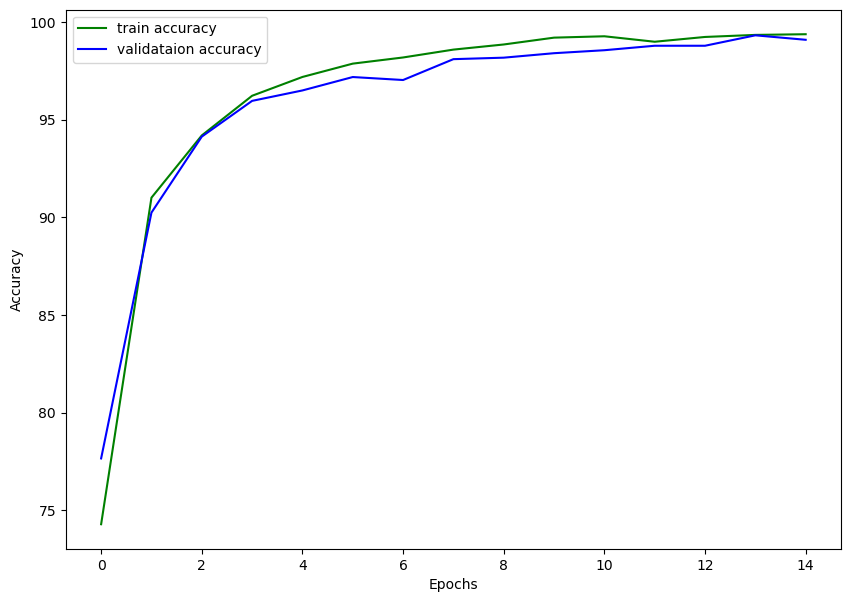

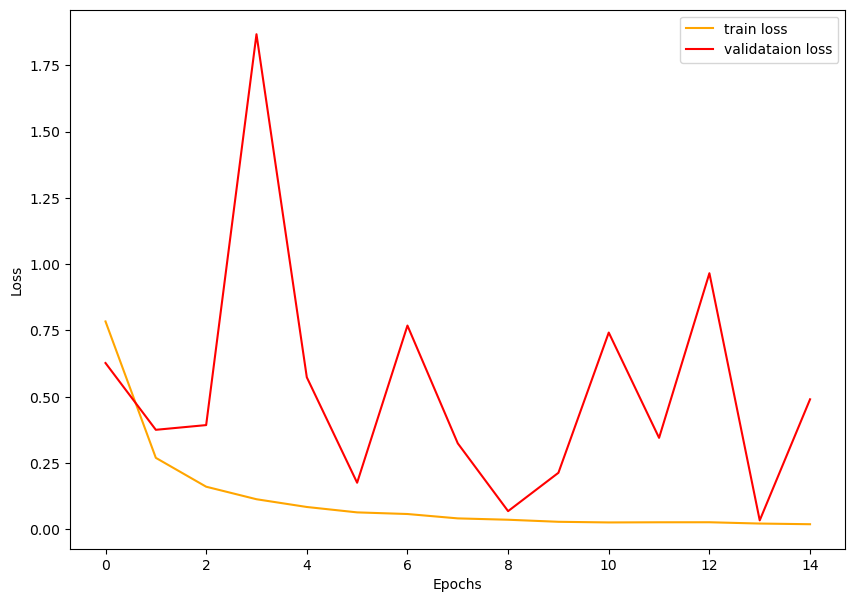

In [7]:
   # Load the training and validation datasets.


dataset_train, dataset_valid, dataset_classes = get_datasets()
print(f"[INFO]: Number of training images: {len(dataset_train)}")
print(f"[INFO]: Number of validation images: {len(dataset_valid)}")
print(f"[INFO]: Class names: {dataset_classes}\n")
# Load the training and validation data loaders.
train_loader, valid_loader = get_data_loaders(dataset_train, dataset_valid)

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}")
print(f"Learning rate: {lr}")
print(f"Epochs to train for: {epochs}\n")
model = build_model(
    pretrained=True,
    fine_tune=True,
    num_classes=len(dataset_classes)
).to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")
# Optimizer.
optimizer = optim.Adam(model.parameters(), lr=lr)
# Loss function.
criterion = nn.CrossEntropyLoss()
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch + 1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, optimizer, criterion, device=device)
    valid_epoch_loss, valid_epoch_acc = validate(model, valid_loader, criterion, device=device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    print("-" * 50)
    time.sleep(5)

# Save the trained model weights
save_model(epochs, model, optimizer, criterion)
# Save the loss and accuracy plots
save_plots(train_acc, valid_acc, train_loss, valid_loss)
print("Training complete!")
